# 準備

In [1]:
# GPU の確認
!nvidia-smi

Wed Sep 16 01:57:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Google Drive のマウント（Google Drive のファイルを読み書きできるようにする）
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 事前に upload したファイルを Google Drive からコピー

data_path = "/content/drive/My Drive/Colaboratory/jts_5/data/"

import shutil
import os
to_data_dir = "data/"
os.makedirs(to_data_dir, exist_ok=True)

fname_list = ["train.zip", "test.zip", "train.csv", "test.csv"]
for fname in fname_list:
    shutil.copy(data_path + fname, to_data_dir + fname)

In [4]:
# 事前に upload した zipファイルを解凍
%cd data
!unzip -qq -n train.zip
!unzip -qq -n test.zip
%cd ../

/content/data
/content


# メイン処理

## import

In [5]:
import os
import random
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## 各種設定

In [6]:
# 各種設定
BATCH_SIZE = 50
MAX_EPOCH = 25
IMAGE_SIZE = 224
# シード値の固定
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# GPU利用設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

device = cuda


## データセット

In [7]:
# 自作のデータセットの処理
class MyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_transform=None, loader=default_loader):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir  # 画像が入っているディレクトリのパス
        self.loader = loader
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    # dataloaderで読み込むときの処理
    def __getitem__(self, idx):
        # filename取得
        img_name = self.df.iloc[idx, 0]
        # 画像のパス設定
        img_path = os.path.join(self.root_dir, img_name)
        # 画像読み込み
        image = self.loader(img_path)
        # user_id = self.df.iloc[idx, 2]

        label = self.df.iloc[idx, 1]

        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)

        return image, label, img_path


# データの前処理を定義
transform = transforms.Compose(
    [
        # 画像のリサイズ
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        # tensorに変換
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]
)

# 訓練用のデータ前処理を定義
train_transform = transforms.Compose(
    [
        # 画像のリサイズ
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        # ここにData augmentation処理を記述する
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.9, contrast=0.9),
        # tensorに変換
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]
)

# 訓練データを取得
train_dataset = MyDataset(
    csv_file="./data/train.csv",
    root_dir='./data/train/',  # 画像を保存したディレクトリ(適宜書き換えて)
    transform=transform,
)
# 訓練データの一部を検証データとして使用
num_train = len(train_dataset)
train_dataset, valid_dataset = torch.utils.data.random_split(
    train_dataset,
    [int(num_train * 0.8), int(num_train * 0.2)],
)
# DataLoaderを作成

# 訓練時のtransformを設定
train_dataset.dataset.transform = train_transform

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
# テストデータも同様
test_dataset = MyDataset(
    "./data/test.csv",
    root_dir='./data/test/',
    transform=transform,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

## モデル

In [8]:
# ニューラルネットワーク
model = models.resnet18(pretrained=True)
# print(model)
model.fc = nn.Linear(512, 2)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


## 学習・評価

processing train data ...
epoch	train loss	valid loss	valid accuracy	processed time
0	0.381316	0.151824	0.950000	6.340959
1	0.138071	0.286193	0.925000	12.587118
2	0.076920	0.080360	0.975000	18.722942
3	0.050169	0.095370	0.958333	24.916203
4	0.041660	0.105847	0.950000	30.952180
5	0.032906	0.069400	0.975000	36.998587
6	0.022910	0.070044	0.966667	43.028246
7	0.018851	0.038937	0.975000	49.022339
8	0.046971	0.070093	0.958333	55.080005
9	0.019234	0.083887	0.966667	61.087297
10	0.029169	0.100423	0.958333	67.114003
11	0.010949	0.080335	0.983333	73.133030
12	0.012606	0.180377	0.941667	79.274606
13	0.012082	0.059035	0.966667	85.269778
14	0.008537	0.090375	0.975000	91.305066
15	0.011925	0.093764	0.966667	97.337928
16	0.013101	0.101394	0.958333	103.356812
17	0.012540	0.067700	0.966667	109.419666
18	0.017805	0.101213	0.983333	115.462393
19	0.008957	0.062570	0.958333	121.417493
20	0.016853	0.073909	0.950000	127.345604
21	0.006975	0.080995	0.958333	133.291777
22	0.011078	0.031767	0.991667	139.270239


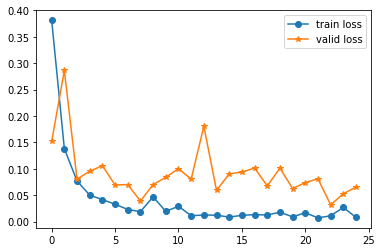

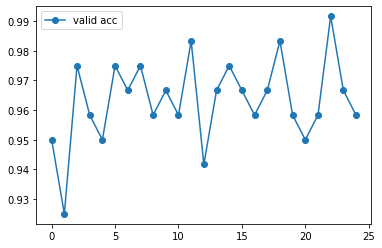

In [9]:
# 損失関数
loss_function = nn.CrossEntropyLoss()
# 勾配降下法を行うoptimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

start = time.time()
print('processing train data ...')

v_acc = []
t_acc = []
best_v_acc = 0
v_accuracy = []
print("epoch\ttrain loss\tvalid loss\tvalid accuracy\tprocessed time")
for epoch in range(MAX_EPOCH):
    model.train()
    train_loss_list = []
    # DataLoaderをfor文で回すと入力と正解ラベルが得られる
    for x, label, img_path in train_loader:
        x = x.to(device)
        label = label.to(device)
        # 勾配を0に初期化
        optimizer.zero_grad()
        # 順伝播
        output = model(x)
        # 誤差の計算
        loss = loss_function(output, label)
        # 誤差逆伝播
        loss.backward()
        # パラメータ更新
        optimizer.step()
        # ミニバッチの訓練誤差をlistに追加
        train_loss_list.append(loss.item())
    # 各ミニバッチでの訓練誤差の平均を取り，本エポックでの訓練誤差とする
    train_loss_mean = np.mean(train_loss_list)

    # 検証データでも同様に誤差を計算
    # モデルを評価する時は model.eval() とする
    model.eval()
    valid_loss_list = []
    valid_correct, valid_total = 0, 0
    for x, label, img_path in valid_loader:
        x = x.to(device)
        label = label.to(device)

        output = model(x)
        loss = loss_function(output, label)
        valid_loss_list.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        # 正解ラベルと比較，一致している数を加算
        valid_correct += pred.eq(label.view_as(pred)).sum().item()
        # 正解率(accuracy)を出すためにテストデータの数も加算
        valid_total += label.size()[0]

    valid_loss_mean = np.mean(valid_loss_list)

    valid_accuracy = valid_correct / valid_total

    print("{0}\t{1:.6f}\t{2:.6f}\t{3:.6f}\t{4:.6f}".format(epoch, train_loss_mean, valid_loss_mean, valid_accuracy, time.time() - start))
    t_acc.append(train_loss_mean)
    v_acc.append(valid_loss_mean)
    v_accuracy.append(valid_accuracy)
    # モデル保存
    if valid_accuracy > best_v_acc:
        best_v_acc = valid_accuracy
        model_dir = "./model/"
        os.makedirs(model_dir, exist_ok=True)
        save_path = model_dir + "cnn.pt"
        torch.save(model.state_dict(), save_path)

# 可視化コード
fig, ax = plt.subplots(1,1)
ax.plot(t_acc, label="train loss", marker="o")
ax.plot(v_acc, label="valid loss", marker="*")
ax.legend()
plt.savefig("losscurve.png", bbox_inches="tight")

fig, ax = plt.subplots(1,1)
ax.plot(v_accuracy, label="valid acc", marker="o")
ax.legend()
plt.savefig("acccurve.png", bbox_inches="tight")

# モデル読込
model.load_state_dict(torch.load("./model/cnn.pt"))

# モデルの評価(テストデータを使用)
print('processing test data ...')
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
for x, label, img_path in test_loader:
    x = x.to(device)
    label = label.to(device)
    output = model(x)
    loss = loss_function(output, label)
    # 出力値が最大のインデックスを取得
    pred = output.argmax(dim=1, keepdim=True)
    # 正解ラベルと比較，一致している数を加算
    test_correct += pred.eq(label.view_as(pred)).sum().item()
    # 正解率(accuracy)を出すためにテストデータの数も加算
    test_total += label.size()[0]

test_accuracy = test_correct / test_total
print("Test accuracy :", test_accuracy)

## 演習用 混同行列の出力・不正解画像の出力

In [10]:
# 演習 Fine-Tuning
# TODO 混同行列の出力
# TODO 不正解だった画像の出力

# モデル読込
model.load_state_dict(torch.load("./model/cnn.pt"))

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # データセットのtransformで行った正規化処理の逆変換
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

model.eval()
softmax = nn.Softmax()
image_path_list = []
for n, (x, label, img_path) in enumerate(test_loader):
    x = x.to(device)
    output = model(x).to("cpu")
    pred = output.argmax(dim=1).to("cpu")
    prob = softmax(output).to("cpu")

    # 混同行列用に予測ラベル，正解ラベルを結合
    preds = pred if n == 0 else torch.cat([preds, pred])
    labels = label if n == 0 else torch.cat([labels, label])
    # 画像確認
    for img, pred_label, true_label, path, p in zip(x.to("cpu"), pred, label, img_path, prob):
        if pred_label != true_label:
            title = "{0} cat:{1:.2f}, dog:{2:.2f}".format(path, p[0], p[1])
            imshow(img, title=title)

cm = confusion_matrix(labels, preds)
print("混同行列")
print(cm)

Output hidden; open in https://colab.research.google.com to view.